Ce notebook montre comment entraîner un espace de représentation multimodal. Le jeu de données traîté est un sous-ensemble de MSCOCO qui contient des images et des légendes textuelles pour ces images. Le problème est simple. Pour la modalité image et la modalité texte, il faut créer des représentations de taille fixe qui soient projetées dans le mêm espace.

Pour rendre le problème manipulable, un sous-ensemble de 10000 couples (image, légende) a été sélectionné. Les images ont été préalablement traitées à l'aide d'un réseau ResNet pour obtenir des représentations de tail 2048 qui servirons d'entrées pour le côté image. Le texte a été tokenisé.

Ces données sont disponibles dans un zip qu'il faut télécharger. Les fichiers qui nous intéressent sont :
* `resnet50-features.10k.npy`, un tenseur numpy contenant pour chaque image sa représentation ResNet 
* `annotations.10k.txt`, un fichier texte contenant sur chaque ligne un nom de fichier pour une image et une légende tokenisée.

In [ ]:
%%bash
curl -sO https://pageperso.lis-lab.fr/benoit.favre/dl4nlp/tutorials/05-caption.zip
unzip -o 05-caption.zip

Archive:  05-caption.zip
  inflating: 05-caption/embedding.py  
  inflating: 05-caption/resnet50-features.10k.npy  
  inflating: 05-caption/05-caption.pdf  
  inflating: 05-caption/glove.twitter.27B.100d.filtered.txt  
  inflating: 05-caption/imagenet_utils.py  
  inflating: 05-caption/annotations.10k.txt  
  inflating: 05-caption/resnet50.py  


In [ ]:
!head 05-caption/annotations.10k.txt

COCO_val2014_000000156276.jpg the rainbow is shining just above the water
COCO_val2014_000000019102.jpg a couple of zebras are standing in the dirt
COCO_val2014_000000126098.jpg a child on a field blocking a soccer ball
COCO_val2014_000000316254.jpg a model poses with a cell phone at a convention
COCO_val2014_000000389812.jpg a man holding a bunch of ripe bananas
COCO_val2014_000000492323.jpg a young male baseball player on a field
COCO_val2014_000000191845.jpg a crowded street of people all with umbrellas
COCO_val2014_000000057904.jpg a close-up of a cut pastry with ice cream on
COCO_val2014_000000385322.jpg a black and white photo of a wooden pier
COCO_val2014_000000195862.jpg a little girl sitting on a big horse


La lecture du fichiers de légendes est relativement simple. On peut voir dans la distribution des longueurs des légendes qu'aucune ne dépasse la longeur 16.

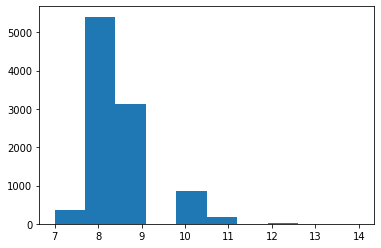

In [ ]:
texts = []
images = []
with open('05-caption/annotations.10k.txt') as fp:
  for line in fp:
    tokens = line.strip().split()
    images.append(tokens[0])
    texts.append(tokens[1:])

from matplotlib import pyplot as plt
plt.hist([len(text) for text in texts])
plt.show()

Nous utiliserons pytorch pour l'apprentissage. Il est possible de changer le type d'accélérateur pour les calculs entre `'cpu'` et `'cuda'`.

La taille que nous ciblons pour l'espace de représentation multimodal est indiquée dans la variable `representation_size`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

maxlen = 16
batch_size = 16
embed_size = 100
hidden_size = 256
resnet_size = 2048
representation_size = 256

device = torch.device('cuda')

Les légendes doivent ensuite être converties en tenseurs. Pour cela il faut construire un vocabulaire dont le mot d'indice 0 est `<eos>` qui signifie la fin de séquence (ou padding).

In [ ]:
import collections

vocab = collections.defaultdict(lambda: len(vocab))
vocab[0] = '<eos>'

X_text = torch.zeros(len(texts), maxlen).long()
for i, text in enumerate(texts):
  length = min([len(text), maxlen])
  X_text[i,:length] = torch.LongTensor([vocab[word] for word in text[:length]])

print(X_text.shape)
print(len(vocab))

torch.Size([10000, 16])
4614


Le chargement des représentations pour les images est très simple, puisqu'il suffit de charger le tenseur avec numpy et de le convertir en tenseur pytorch.

In [ ]:
import numpy as np

X_image = torch.tensor(np.load('05-caption/resnet50-features.10k.npy'))
X_image.shape

torch.Size([10000, 2048])

Nous utiliserons 90% des données pour l'apprentissage et le reste pour la validation. Il ne faut pas oublier d'envoyer ces données sur l'accélérateur (GPU si device = cuda).

In [ ]:
X_train_text = X_text[:9000].to(device)
X_train_image = X_image[:9000].to(device)

X_valid_text = X_text[-1000:].to(device)
X_valid_image = X_image[-1000:].to(device)

print(X_train_text.shape, X_train_image.shape)
print(X_valid_text.shape, X_valid_image.shape)

torch.Size([9000, 16]) torch.Size([9000, 2048])
torch.Size([1000, 16]) torch.Size([1000, 2048])


Les données seront présentées batch par batch lors de l'apprentissage après avoir été mélangées aléatoirement. Ce mélange est important comme nous allons le voir par la suite.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(X_train_text, X_train_image)
valid_set = TensorDataset(X_valid_text, X_valid_image)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

Le modèle utilise un GRU unidirectionnel pour les légendes, puis l'état caché après le dernier mot est projeté dans l'espace multimodal. Côté image, on n'effectue que la projection vers l'espace multimodal. Des fonctions `forward_text` et `forward_image` calculent les représentations repsectives dans les deux modalités.

La fonction forward est celle qui sera utilisée pour l'apprentissage. L'idée est de calculer une similarité entre une paire de représentation (texte, image). On calcule cette valeur pour 3 paires :
* positives: les paires existantes du corpus d'apprentissage
* negative1: on remplace le texte par un imposteur
* negative2: on remplace l'image par un imposteur

Les imposteurs sont choisis dans le même batch, en prenant l'élément d'indice suivant modulo la taille du batch. Ceci souligne l'importance que les batches contiennent des données mélangées aléatoirement à chaque époque.

Notez que la similarité choisie est le cosinus. Il est calculé en normalisant les représentations (norme L2, dans les fonctions `forward_*` unimodales), puis en effectuant le produit scalaire entre ces dernières (fonction `bmm` pour le faire par batch). 

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(len(vocab), embed_size)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.text_to_representation = nn.Linear(hidden_size * 1 * 1, representation_size)
    self.image_to_representation = nn.Linear(resnet_size , representation_size)
    self.to(device)
      
  def forward_text(self, x):
    embed = self.embed(x)
    output, hidden = self.rnn(embed)
    drop = self.dropout(hidden)
    return F.normalize(self.text_to_representation(drop.transpose(0, 1).contiguous().view(x.size(0), -1)), p=2, dim=1)

  def forward_image(self, x):
    drop = self.dropout(torch.relu(x))
    return F.normalize(self.image_to_representation(drop), p=2, dim=1)

  def forward(self, x_text, x_image):
    assert len(x_text) == len(x_image) and len(x_text) > 1
    # shift batch index by 1 to make impostors
    impostors = torch.arange(-1, len(x_text) - 1).to(device) 
    
    text_rep = self.forward_text(x_text)
    text_impostors = self.forward_text(x_text[impostors])
    image_rep = self.forward_image(x_image)
    image_impostors = self.forward_image(x_image[impostors])

    positives = torch.bmm(text_rep.unsqueeze(1), image_rep.unsqueeze(2))
    negatives1 = torch.bmm(text_impostors.unsqueeze(1), image_rep.unsqueeze(2))
    negatives2 = torch.bmm(text_rep.unsqueeze(1), image_impostors.unsqueeze(2))

    return positives.squeeze(), negatives1.squeeze(), negatives2.squeeze()

model = Model()

On peut tester le modèle pour vérifier qu'il renvoie les bonnes tailles de tenseurs.

In [ ]:
with torch.no_grad():
  print(model.forward_text(X_train_text[:2]).shape)
  print(model.forward_image(X_train_image[:2]).shape)
  positives, negatives1, negatives2 = model(X_train_text[:2], X_train_image[:2])
  print(positives.shape, negatives1.shape, negatives2.shape)

torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2]) torch.Size([2]) torch.Size([2])


Si $p$ sont les prédictions positives, $n_1$ et $n_2$ les prédictions où il y a des imposteurs, le critère d'apprentissage de type large marge est : 
\begin{equation}
\text{loss}(p,n_1,n_2)=\sum \max\left(0, 1 - p + \frac{n_1 + n_2}{2} \right)
\end{equation}

Une manière d'évaluer ce type de système est de compter le nombre de fois où le score des paires positives est plus grand que celui des paires négatives. C'est ce que fait la fonction `eval_correct`. Notez que cette évaluation n'est pas très informative sur la qualité de l'espace produit. 

In [ ]:
def criterion(positives, negatives1, negatives2):
  return torch.sum(torch.clamp(1. - positives + (negatives1 + negatives2) / 2, min=0))

def eval_correct(positives, negatives1, negatives2):
  return torch.sum(positives > negatives1).item() + torch.sum(positives > negatives2).item()

L'évaluation des performances sur les données d'évaluation ne fait qu'appliquer les deux fonctions définies précédemment. On attent qu'en terme de pourcentage de correct, un modèle initialisé aléatoirement sans apprentissage obtienne 50% de bonnes réponses.

In [ ]:
def perf(model, loader):
  model.eval()
  total_loss = correct = num = 0
  with torch.no_grad():
    for x1, x2 in loader:
      positives, negatives1, negatives2 = model(x1, x2)
      loss = criterion(positives, negatives1, negatives2)
      correct += eval_correct(positives, negatives1, negatives2)
      total_loss += loss.item()
      num += len(positives) * 2
  return total_loss / num, correct / num

perf(model, valid_loader)

(0.49999331855773926, 0.5185)

L'apprentissage est très similaire à l'évaluation, mais effectue la minimisation de la fonction de coût à l'aide d'un optimiseur. Après 10 à 20 époques, les performances sur la validation devraient saturer entre 80 et 90%.

In [ ]:
def fit(model, epochs):
  optimizer = optim.Adam(model.parameters())
  for epoch in range(epochs):
    model.train()
    total_loss = num = 0
    for x1, x2 in train_loader:
      optimizer.zero_grad()
      positives, negatives1, negatives2 = model(x1, x2)
      loss = criterion(positives, negatives1, negatives2)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      num += len(positives) * 2
    print(epoch, total_loss / num, *perf(model, valid_loader))

model = Model()
fit(model, 20)

0 0.09314164305229981 0.14302334666252137 0.9195
1 0.09575590980466869 0.14259090632200241 0.9215
2 0.09492065587432848 0.14234741812944413 0.9205
3 0.09640624221145279 0.14206264638900756 0.9215
4 0.09614101780123181 0.1419065632224083 0.921
5 0.09654113975995117 0.14170469444990158 0.9215
6 0.09482483330575957 0.1415113629102707 0.921
7 0.09700385307106707 0.1413684051632881 0.921
8 0.09542316496661968 0.1412176982164383 0.922
9 0.09635059539145893 0.14112390905618669 0.922
10 0.09317061232030392 0.1410147789120674 0.922
11 0.09596598749028312 0.14094176852703094 0.921
12 0.09138469543225236 0.14082519710063934 0.9215
13 0.09078996858373284 0.14077424031496047 0.923
14 0.09166333352194891 0.14069774097204207 0.923
15 0.0933293203379338 0.14058533817529678 0.9225
16 0.0943543398876985 0.14051307570934296 0.923
17 0.09587092265652286 0.14043914568424226 0.9225
18 0.09173045706666179 0.14038877230882646 0.922
19 0.09288696888337533 0.14034286308288574 0.922


On peut alors récupérer les représentations mulitmodales apprises pour les données du jeu d'évaluation.

In [ ]:
import torch.nn.functional as f

with torch.no_grad():
  U_text = model.forward_text(X_valid_text).cpu()
  print(U_text.shape)
  U_image = model.forward_image(X_valid_image).cpu()
  print(U_image.shape)

torch.Size([1000, 256])
torch.Size([1000, 256])


Pour se donner une idée de ce à quoi ressemble l'espace de représentation, on peut faire une projection T-SNE en 2 dimensions, puis utiliser le widget jupyter "big_scatter" pour afficher le résultat. Bouger la souris sur ce widget permet d'explorer les images (points bleus) et légendes (points rouges). On voit que globalement les deux espaces ont bien été mappés, mais que localement l'appariement n'est pas très précis. 

Apprendre sur plus de données, de manière plus fine en raffinant par exemple le réseau ResNet côté image, et en sélectionnant les imposteurs permet d'obtenir de meilleurs espaces multimodaux. Leur évaluation peut être faite à travers leur impact sur un ensemble de tâches aval.

In [ ]:
!curl -sO https://pageperso.lis-lab.fr/benoit.favre/files/big_scatter.py
!pip -q install tsne
import big_scatter
from tsne import bh_sne

def plot_projection(embedding):
  projection = bh_sne(embedding.astype(np.float64))
  url = '<img src="https://pageperso.lis-lab.fr/benoit.favre/tsne-captions/images/%s" height="48">'
  labels = [' '.join(texts[i + 9000]) for i in range(1000)] + [url % images[i + 9000] for i in range(1000)]
  colors = ['rgba(255,0,0,.5)' for i in range(1000)] + ['rgba(0,0,255,.5)' for i in range(1000)]
  big_scatter.draw(projection, labels, width="50%", color=colors, size=3, shape='circle', html_labels=True)

plot_projection(np.concatenate([U_text, U_image]))